In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    import numpy as np
from TDD.TDD import Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx

In [2]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for n in range(10):
            for k in range(50):
                s ='x'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)               
                
        
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd1,tdd)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

In [3]:
def get_dependency_cycle(tdd,reduced=False):
    n = (tdd.node.key+1)//2
    G = nx.Graph()
    for k in range(n):
        the_map1,w1 = get_downward_k_level_map(tdd,k,0)
        the_map2,w2 = get_downward_k_level_map(tdd,k,1)
        if the_map1.level!= 2*n-2-2*k:
            G.add_edge(2*n-1-2*k, 2*n-2-2*k,map={'x': 0, 'rotate': 0,'w':(w1,w2)})
        else:
            G.add_edge(2*n-1-2*k, 2*n-2-2*k,map={'x': the_map1.x, 'rotate': the_map1.rotate,'w':(w1,w2)})
        
        while the_map1.level>-1:
            if the_map1.level<2*n-2-2*k:
                if not reduced or (the_map1.level)%2==0:
                    G.add_edge(2*n-1-2*k, the_map1.level,map={'x': the_map1.x, 'rotate': the_map1.rotate})
            the_map1=the_map1.father
        while the_map2.level>-1:
            if the_map2.level<2*n-2-2*k:
                if not reduced or (the_map2.level)%2==1:
                    G.add_edge(2*n-2-2*k, the_map2.level,map={'x': the_map2.x, 'rotate': the_map2.rotate})
            the_map2=the_map2.father

    return G

def reduce_graph(tdd,G):
    n = (tdd.node.key+1)//2
    flag = True
    while flag:
        flag = False
        for idx in range(2*n-1,-1,-1):
            if idx in G:
                A = list(G.neighbors(idx))
                if len(A)==1:
                    G.remove_node(idx)
                    G.remove_node(A[0])
                    flag = True
    return G

In [4]:
def eliminate_global_map(tdd):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)


    if tdd.map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    the_map=tdd.map
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if idx%2==1:
            if the_map.rotate>0:
                cir_head.p(np.pi/4*(8-the_map.rotate),q)
            if the_map.x==1:
                cir_head.x(q)
        else:
            if the_map.x==1:
                cir_end.x(q)
            if the_map.rotate>0:
                cir_end.p(np.pi/4*(8-the_map.rotate),q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    return tdd_new,cir_head,cir_end

In [5]:
def get_border_control_pos(tdd,G):
    res = []
    for idx in range(tdd.node.key,-1,-1):
        A = list(G.neighbors(idx))
        for idx2 in A:
            if idx2%2==idx%2 and idx2<idx:
                res.append([idx,idx2])
    return res
            

def eliminate_border_control(tdd,G=None):

    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
    res = get_border_control_pos(tdd,G)
    # print(res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
        
    for [idx1,idx2] in res:
        q_c = int(tdd.key_2_index[idx1][1:])
        q = int(tdd.key_2_index[idx2][1:])
        # print(q_c,q)
        temp_map = G.edges[idx1,idx2]['map']
        if idx1%2==1:
            if temp_map['rotate']>0:
                cir_head.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            if temp_map['x']==1:
                cir_head.cx(q_c,q)
        else:
            if temp_map['x']==1:
                cir_end.cx(q_c,q)
            if temp_map['rotate']>0:
                cir_end.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t 
    return tdd_new,cir_head,cir_end

In [6]:
def get_sigle_qubit_gates(tdd,G):
    res = {}
    for idx in range(tdd.node.key,-1,-1):
        if not idx in G:
            continue
        A = list(G.neighbors(idx))
        idx1=-1

        if len(A)==1:
            if idx%2==1:
                idx1=idx
            elif not (idx+1) in res:
                idx1=idx+1
            if idx1==-1:
                continue

            temp_map = G.edges[idx1,idx1-1]['map']
            w = temp_map['w']
            M = np.zeros([2,2],dtype=complex)
            M[0][0]=M[0][1]=1
            a = w[1]
            M[1][0] = a
            if temp_map['rotate']>0:
                a*=np.exp(1j*np.pi/4*(temp_map['rotate']))
                M[1][1]=a
            if temp_map['x']==1:
                M[0][1],M[1][1] = M[1][1],M[0][1]
            M/= np.sqrt(abs(M[0][0])**2+abs(M[0][1])**2)
            # print(M)
            if M[0][0]==M[1][1]==1:
                continue
            M_conj=M.T.conjugate()
            err=sum(sum(abs(M.dot(M_conj)-np.eye(2))))
            if err>1e-8:
                print('Not Unitary')
                continue
            M=M_conj
            res[idx] = M
    return res


def eliminate_sigle_qubit_gates(tdd,G=None):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)

    res = get_sigle_qubit_gates(tdd,G)
    # print('a',res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
        
    for idx in res:
        q = int(tdd.key_2_index[idx][1:])
        M = res[idx]
        if idx%2==1:
            cir_head.unitary(M,q)
        else:
            cir_end.unitary(M,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t

    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
            
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print('b',res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t        
    return tdd_new,cir_head,cir_end

In [7]:
def get_partial_control_pos(tdd,G):
    res = {}
    for idx in range(tdd.node.key,-1,-1):
        if idx%2==1:
            A = list(G.neighbors(idx))
            B = list(G.neighbors(idx-1))
            if len(A)>1 and len(B)==1:
                # print(idx,A,B)
                A.remove(idx-1)
                B.remove(idx)
                if len(A)>0 or len(B)>0:
                    res[idx] = A+B
        else:
            A = list(G.neighbors(idx))
            B = list(G.neighbors(idx+1))
            if len(A)>1 and len(B)==1:
                A.remove(idx+1)
                B.remove(idx)
                if len(A)>0 or len(B)>0:
                    res[idx] = A+B
                
    return res
            

def eliminate_partial_control(tdd,G=None):

    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
    res = get_partial_control_pos(tdd,G)
    # print(res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
    calculted = []
    for idx1 in res:
        for idx2 in res[idx1]:
            if [idx2,idx1] in calculted:
                continue
            # print(idx1,idx2)
            q_c = int(tdd.key_2_index[max(idx1,idx2)][1:])
            q = int(tdd.key_2_index[min(idx1,idx2)][1:])
            # print(q_c,q)
            temp_map = G.edges[idx1,idx2]['map']
            if idx2%2==1:
                if temp_map['rotate']>0:
                    cir_head.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
                if temp_map['x']==1:
                    cir_head.cx(q_c,q)
            else:
                if temp_map['x']==1:
                    cir_end.cx(q_c,q)
                if temp_map['rotate']>0:
                    cir_end.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            calculted.append([idx1,idx2])
    # print(cir_head)
    # print(cir_end)
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print(res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_partial_control_pos(tdd_new,G)
    # print('aa',res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_partial_control(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [8]:
def find_entangel_indices(tdd,G=None,calculated=[]):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd,True)
    G = reduce_graph(tdd,G)

    idxs = []
    
    cycles = list(nx.cycle_basis(G))
    if not cycles:
        return idxs

    idxs = []

    for l in range(len(cycles)):
        cycles[l].sort()
        cycles[l].reverse()
        # print(cycles[l])
        idx1=-1
        for idx0 in cycles[l]:
            A = list(G.neighbors(idx0))
            for k in range(idx0-1,-1,-1):
                if k in cycles[l] and k in A and k//2!=idx0//2:
                    idx1=k
                    if not [idx0,idx1] in calculated:
                        # if [idx0,idx1] not in idxs:
                            idxs.append([idx0,idx1])
                        # if idx0%2==1:
                        #     if [idx0-1,idx1+1] not in idxs:
                        #         idxs.append([idx0-1,idx1+1])
                        # if idx0%2==0:
                        #     if [idx0+1,idx1-1] not in idxs:
                        #         idxs.append([idx0+1,idx1-1])

    return idxs

def eliminate_entangel_through_swap(tdd,G=None,calculated1={}):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    if tdd.node_number()>2*n+1:
        print('Is not tower form')
        return tdd,cir_head,cir_end      
    if G==None:
        G = get_dependency_cycle(tdd,True)
        
    idxs = find_entangel_indices(tdd,G,calculated=[])
    # print(idxs)
    if len(idxs)==0:
        return tdd,cir_head,cir_end
    
    
    
    flag = False
    id0=0
    id1=0
    for [idx0,idx1] in idxs:
        if tdd.node in calculated1:
            if [idx0,idx1] in calculated1[tdd.node]:
                continue
        cir_head_t = QuantumCircuit(n)
        cir_end_t = QuantumCircuit(n)        
        q0=int(tdd.key_2_index[idx0][1:])
        q1=int(tdd.key_2_index[idx1][1:])
        # print(idx0,idx1,q0,q1)
        if idx0%2==1:
            cir_head_t.cx(q0,q1)
            cir_head_t.cx(q1,q0)
            cir_head_t.cx(q0,q1)
        else:
            cir_end_t.cx(q0,q1)
            cir_end_t.cx(q1,q0)
            cir_end_t.cx(q0,q1)

        id0=idx0
        id1=idx1
        tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
        tdd_new_t = renormalize(tdd_new_t)
        G_t = get_dependency_cycle(tdd_new_t,True)
        G_t = reduce_graph(tdd_new_t,G_t)
        
        if len(G_t.edges())<len(G.edges):
            flag = True
            break


    if not flag:
        [idx0,idx1] = idxs[0]
        q0=int(tdd.key_2_index[idx0][1:])
        q1=int(tdd.key_2_index[idx1][1:])
        cir_head_t = QuantumCircuit(n)
        cir_end_t = QuantumCircuit(n)            
        cir_head_t.h(q1)
        cir_head_t.cz(q0,q1)
        tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
        tdd_new_t = renormalize(tdd_new_t)
 
    
    if not flag:
        print('Not find one')


    if not tdd.node in calculated1:
        calculated1[tdd.node] = [[id0,id1]]
    else:
        calculated1[tdd.node].append([id0,id1])

    tdd_new = tdd_new_t
    cir_head = cir_head_t
    cir_end = cir_end_t


    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    # print(11,res)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
            
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print(22,res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_partial_control_pos(tdd_new,G)
    # print(33,res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_partial_control(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t   

    G2 = get_dependency_cycle(tdd_new,True)
    idxs=find_entangel_indices(tdd,G2,calculated=[])
    # print(44,idx0,idx1)
    if idxs:
        tdd_new,cir_head_t,cir_end_t = eliminate_entangel_through_swap(tdd_new,G=None,calculated1=calculated1)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [9]:
def syn_tower(tdd):
    """逐层去处理各个level"""
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    tdd_new = tdd.self_copy()
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form')
        return tdd_new,cir_head,cir_end
        
    tdd_new,cir_head_t,cir_end_t=eliminate_global_map(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form')
        return tdd_new,cir_head,cir_end    
    tdd_new,cir_head,cir_end=eliminate_border_control(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form')
        return tdd_new,cir_head,cir_end    
    tdd_new,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form')
        return tdd_new,cir_head,cir_end    
    tdd_new,cir_head,cir_end=eliminate_partial_control(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form')
        return tdd_new,cir_head,cir_end    
    tdd_new,cir_head,cir_end=eliminate_entangel_through_swap(tdd_new,calculated1={})
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    tdd_new = renormalize(tdd_new)
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form')
        return tdd_new,cir_head,cir_end    
    for k in range(n):
        the_map1,_ = get_downward_k_level_map(tdd_new,k,0)
        # print(the_map1.level,the_map1.father.level)
        if the_map1.level != 2*n-2-2*k or the_map1.father.level!=-1 or the_map1.x==0 or the_map1.rotate>0:
            tdd_new,cir_head,cir_end = syn_tower(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
        the_map2,_ = get_downward_k_level_map(tdd_new,k,1)
        # print(the_map2.level)
        if the_map2.level!=-1:
            tdd_new,cir_head,cir_end = syn_tower(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

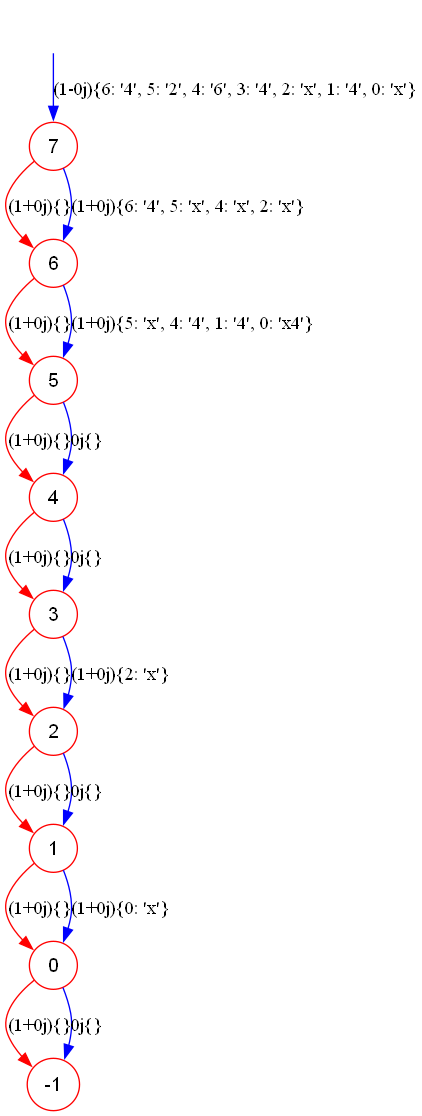

In [25]:
n=4
m=20

cir=gen_cir('Random_Clifford',n,m)
tdd=simulate(cir,True)
tdd.show(False)

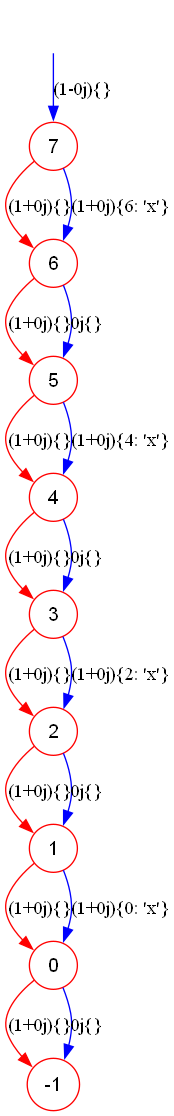

In [26]:
id_tdd,cir_head,cir_end=syn_tower(tdd)
id_tdd.show(False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
Not find one
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
Is not tower form
79
80
81
82
83
84
85
86
87
88
89
90
91
Is not tower form
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
Is not tower form
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
Is not tower form
Is not tower form
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
Is 

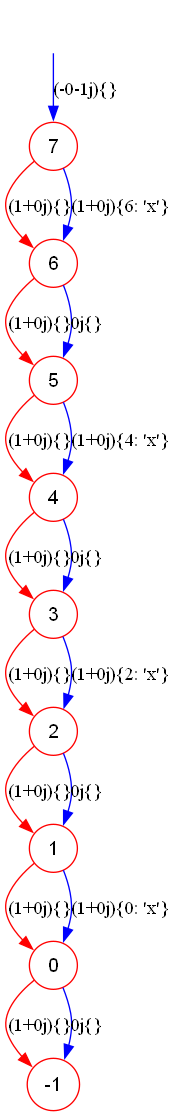

In [12]:
tdd_new2=None
flag=True
# for k in range(100):
k=0
while flag:
    print(k)
    k+=1
    if k>1000:
        break
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd2=simulate(cir,False)
    # print(tdd2.node.key,tdd2.node_number())
    if tdd2.node_number()>9 or tdd2.node.key!=2*n-1:
        continue
    # print(1)
    tdd_new2,cir_head,cir_end=syn_tower(tdd2)
    if tdd_new2.node_number()>9 or tdd_new2.node.key!=2*n-1:
        continue
    if tdd_new2.node!=id_tdd.node or tdd_new2.map.level!=-1:
        flag=False
        print('Find one')
        break
tdd_new2.show(False)

In [27]:
cir.draw()

┌───┐┌───┐┌───┐┌───┐               ┌───┐
q_0: ───────■─────────■──┤ H ├┤ H ├┤ Y ├┤ X ├────────────■──┤ S ├
     ┌───┐  │  ┌───┐  │  └───┘└───┘└───┘└─┬─┘┌───┐┌───┐┌─┴─┐└───┘
q_1: ┤ S ├──┼──┤ X ├──┼────■──────────────■──┤ S ├┤ X ├┤ X ├─────
     └───┘┌─┴─┐├───┤  │    │                 └───┘└───┘└───┘     
q_2: ─────┤ X ├┤ Y ├──┼────┼──────────────■────■─────────────────
     ┌───┐└───┘└───┘┌─┴─┐┌─┴─┐┌───┐┌───┐┌─┴─┐┌─┴─┐┌───┐          
q_3: ┤ X ├──────────┤ X ├┤ X ├┤ H ├┤ H ├┤ X ├┤ X ├┤ Y ├──────────
     └───┘          └───┘└───┘└───┘└───┘└───┘└───┘└───┘

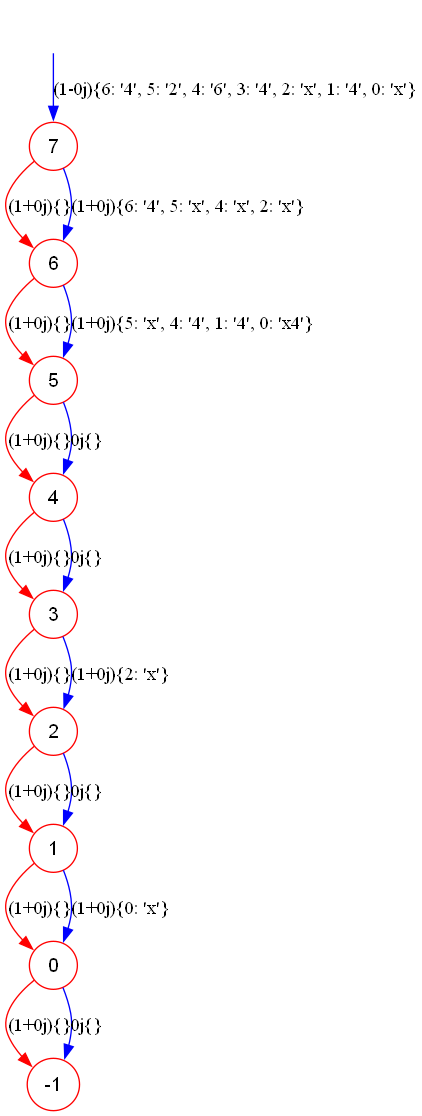

In [28]:
tdd2=simulate(cir,False)
tdd2.show(False)

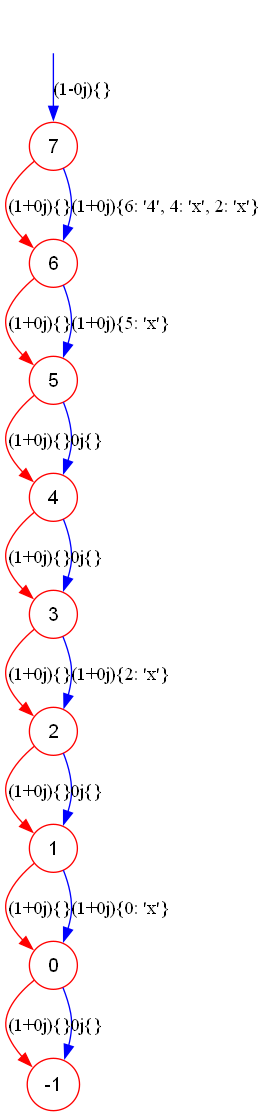

In [29]:
tdd_new,cir_head,cir_end=eliminate_global_map(tdd2)
tdd_new,cir_head,cir_end=eliminate_border_control(tdd_new)
tdd_new,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new)
tdd_new.show(False)

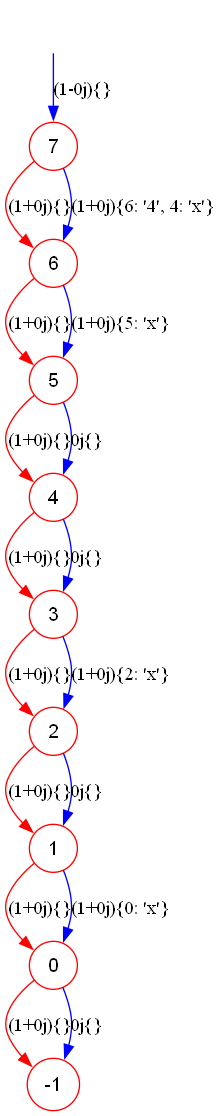

In [30]:
tdd_new,cir_head,cir_end=eliminate_partial_control(tdd_new)
tdd_new.show(False)

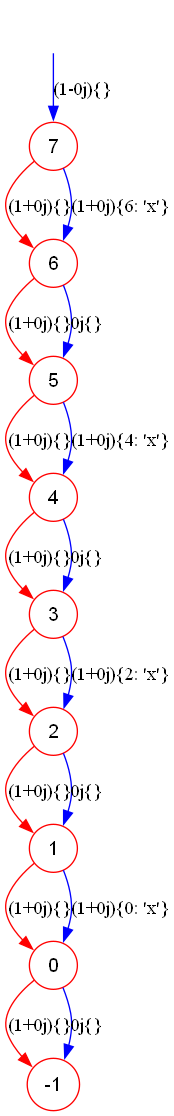

In [31]:
tdd_new,_,_=eliminate_entangel_through_swap(tdd_new,calculated1={})
tdd_new.show(False)

[]


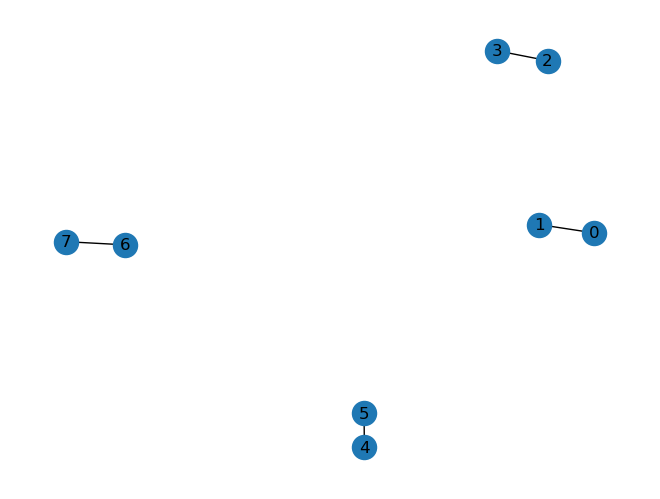

In [32]:
G = get_dependency_cycle(tdd_new,True)
cycles = list(nx.cycle_basis(G))
print(cycles)
nx.draw(G,with_labels=True)